# Proyecto 3 - Aplicaciones Actuales
## Procesamiento del Lenguaje Natural

### Dataset: The Multilingual Amazon Reviews Corpus

Se implementa un modelo para reconocer el puntaje asignado a un ítem de Amazon a partir de la crítica que hace un/a usuario/a.

Puede consultar el repositorio con este notebook e información adicional del proyecto en este [link](https://github.com/danieladiazgo/Acamica).

In [152]:
import itertools


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk
import re

In [153]:
data_dev = pd.read_json ('dataset_es_dev.json',lines=True)
data_test = pd.read_json ('dataset_es_test.json',lines=True)
data_train = pd.read_json ('dataset_es_train.json',lines=True)

### Exploración de datos

Revisaré la forma que tienen los tres conjuntos de datos

In [154]:
data_dev.shape

(5000, 8)

In [155]:
data_test.shape

(5000, 8)

In [156]:
data_train.shape

(200000, 8)

Reviso el número de registros duplicados que hay en el dataset

In [157]:
len(data_train)-len(data_train.drop_duplicates())

0

Reviso si tiene datos nulos

In [158]:
data_train.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

Se observa que no hay datos nulos ni registros duplicados en el dataset. Ahora revisaré qué contiene el dataset

In [159]:
data_train.head(5)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


Ahora revisaré cómo está distribuido el número de estrellas en los datasets.

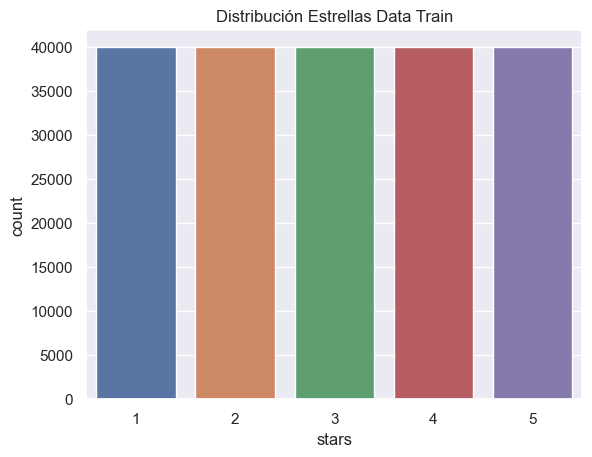

In [160]:
sns.countplot(x=data_train['stars'])
plt.title("Distribución Estrellas Data Train")
plt.show()

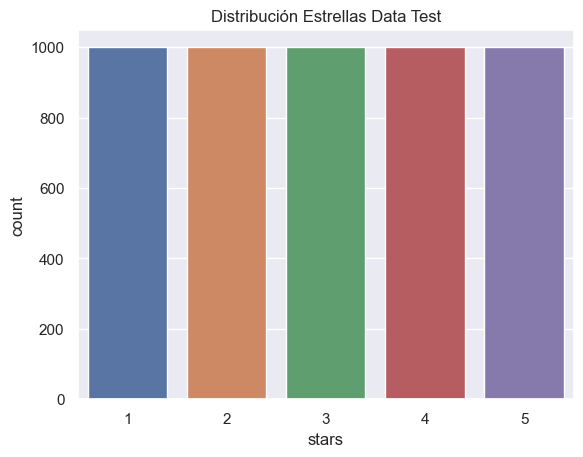

In [161]:
sns.countplot(x=data_test['stars'])
plt.title("Distribución Estrellas Data Test")
plt.show()

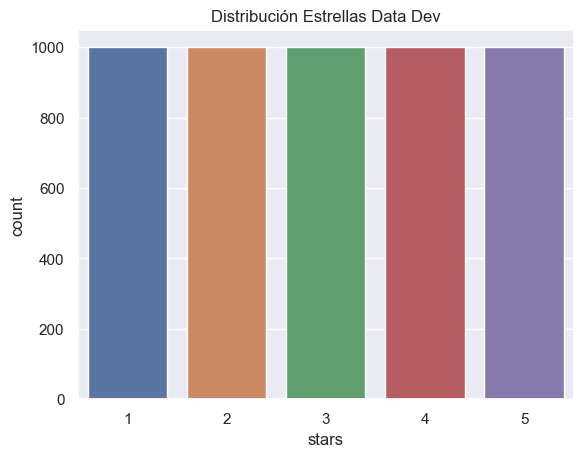

In [162]:
sns.countplot(x=data_dev['stars'])
plt.title("Distribución Estrellas Data Dev")
plt.show()

Se observa que los datasets están muy balanceados en cuanto a las estrellas o calificaciones que es lo que se quiere predecir.

Dado que quiero clasificar una reseña en 1, 2, 3, 4 o 5 estrellas, las columnas que necesito del dataset son stars y review_body.

In [163]:
data_train = data_train[['stars', 'review_body']]

In [164]:
type(data_train)

pandas.core.frame.DataFrame

Voy a revisar para cada clasificación de estrellas cómo están los unigramas y bigramas

In [165]:
#Se crean varios dataframes con los comentarios para cada categoría de estrellas
data_train_1 = data_train[data_train.stars == 1]
data_train_2 = data_train[data_train.stars == 2]
data_train_3 = data_train[data_train.stars == 3]
data_train_4 = data_train[data_train.stars == 4]
data_train_5 = data_train[data_train.stars == 5]  

In [166]:
from contexto.limpieza import *

In [167]:
from contexto.exploracion import grafica_barchart_frecuencias

In [168]:
from nltk.tokenize import RegexpTokenizer

Creo la función grafica_ngramas que utilizando funciones de la librería contexto permite graficar ngramas. Recibe como parámetros un dataset, la columna donde está el texto y si quieres sacar unigrama, bigramas... indicandolo con números enteros mayor que 0

In [169]:
def grafica_ngramas (dataset, column_name, ngrama=1):
    todos = []
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    p = re.compile('\w+')
    for i in range(dataset.shape[0]):
        body = dataset[column_name].iloc[i] #seleccionar el titular
        body = tokenizer.tokenize(body)
        todos.append(body) #agregar el resultado a la lista
    todos = list(itertools.chain(*todos))
    listToStr = ' '.join([str(elem) for elem in todos]) 
    grafica_barchart_frecuencias(listToStr, ngrama, ascendente=True, dim_figura=(7,4))

Saco el unigrama para el conjunto de entrenamiento de una estrella

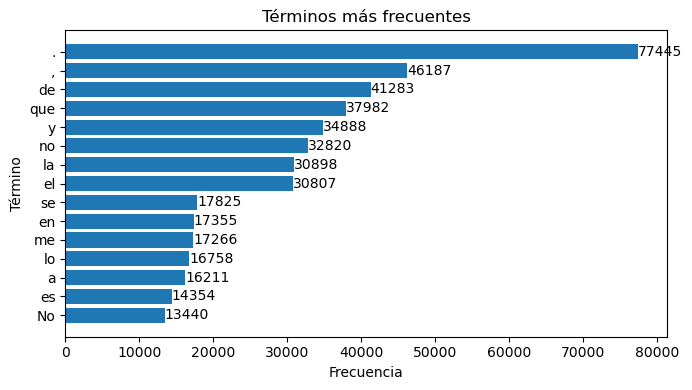

In [170]:
grafica_ngramas(data_train_1,'review_body',1)

Se observa que dado que el dataset no está limpio no puedo obtener información representativa de esto. Voy a limpiarlo y observar cómo se comporta cada una de las categorías

### Limpieza de Datos

Para hacer la limpieza de datos se utilizará la librería Spacy especificamente el modelo para idioma español. Se realizará en el siguiente orden:

1. Se convierte a minúscula
2. Se eliminan caracteres especiales
3. Se eliminan los espacios consecutivos. Sólo se permitirá un espacio entre palabras
4. Se eliminan las stopwords
5. Se limpian los acentos
6. Se dejan las palabras que tengan más de ciertos caracteres. Por defecto la función tiene 3

Una vez tengamos el dataset limpio podemos pasar a la lematización


In [171]:
import spacy

nlp = spacy.load('es_core_news_sm')

In [172]:
stopwords = nlp.Defaults.stop_words

In [173]:
#La funcion limpieza_datos elimina los caracteres especiales y stopwords de un texto dado.
#el parámetro incluir_palabra es para indicar si a pesar de que la palabra esté en stopwords se debe
#conservar en el dataset.
#En nuestro caso se queda porque la considero relevante. Un "funcional" y un "no funcional" podría
#hacer la diferencia entre 1 y 5 estrellas.

def limpieza_datos(text, stop_words, caracteres = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~¿¡1234567890', incluir_palabra=['no']):
    review = str.lower(text) #Convertimos todo a min
    review= re.sub('[%s]' % re.escape(caracteres), '', review) #Eliminamos caracteres especiales
    review=" ".join(re.split("\s+", review, flags=re.UNICODE)).strip() #Eliminamos espacios
    review_list= review.split() #Separamos la reseña en palabras para comparar con las stopwords
    review_list = [word for word in review_list if word not in stop_words or word in incluir_palabra]
    review=' '.join(review_list)
    return review

#El parámetro longitud determina desde que longitud no se van a permitir palabras. Por defecto palabras de
#3 letras o menos no serán tenidas en cuenta. A menos que estén indicadas en el parámetro incluir_palabra
def limpieza_longitud(text, longitud = 3, incluir_palabra = ['no'], activar_incluir = True):
    review_list = text.split()
    if activar_incluir:
        words = [word for word in review_list if word in incluir_palabra or len(word) > longitud]
    else:
        words = [word for word in review_list if len(word) > longitud]
    return ' '.join(words)

def limpieza_acentos(text, acentos = 'áéíóúü', reemplazo = 'aeiouu'):
    review = str.maketrans(acentos,reemplazo)
    return text.translate(review)

def lemmatizar(text):
    review_nlp = nlp(text)
    review_lemma = [word.lemma_ for word in review_nlp]
    return ' '.join(review_lemma)
    

In [174]:
%%time
data_train['review_normalize'] = data_train.review_body.apply(lambda x: limpieza_datos(x, stopwords))


Wall time: 6.91 s


In [175]:
%%time
data_train['review_normalize'] = data_train.review_normalize.apply(lambda x: limpieza_acentos(x))


Wall time: 1.63 s


In [176]:
%%time
data_train['review_normalize'] = data_train.review_normalize.apply(lambda x: limpieza_longitud(x))

Wall time: 983 ms


In [177]:
%%time 
data_train['review_lemmatize'] = data_train.review_normalize.apply(lambda  x: lemmatizar(x))

Wall time: 28min 27s


In [178]:
#Creo nuevamente los 5 datasets con data_train ya normalizado y lemmatizado
data_train_1 = data_train[data_train.stars == 1]
data_train_2 = data_train[data_train.stars == 2]
data_train_3 = data_train[data_train.stars == 3]
data_train_4 = data_train[data_train.stars == 4]
data_train_5 = data_train[data_train.stars == 5]  

### Unigramas

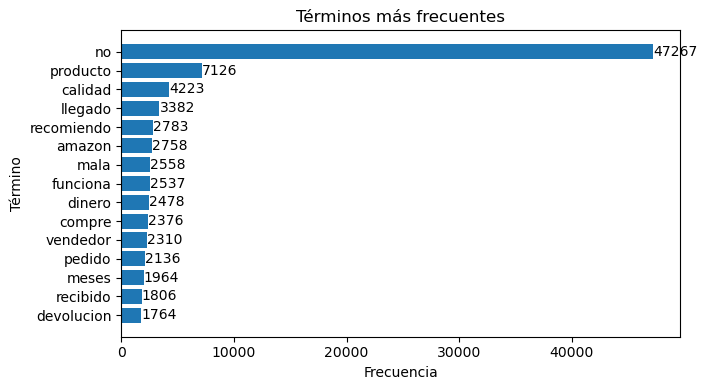

In [179]:
grafica_ngramas(data_train_1,'review_normalize',1)

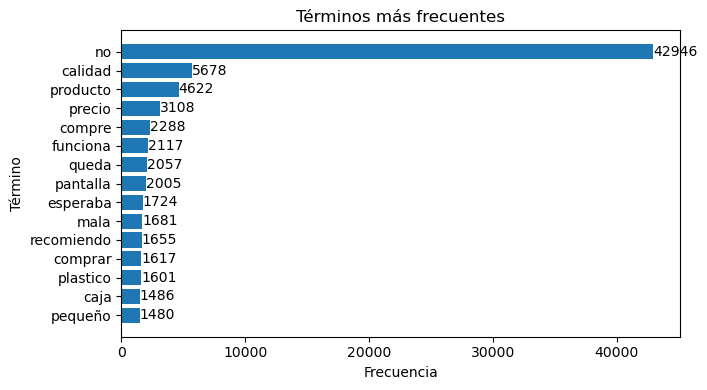

In [180]:
grafica_ngramas(data_train_2,'review_normalize',1)

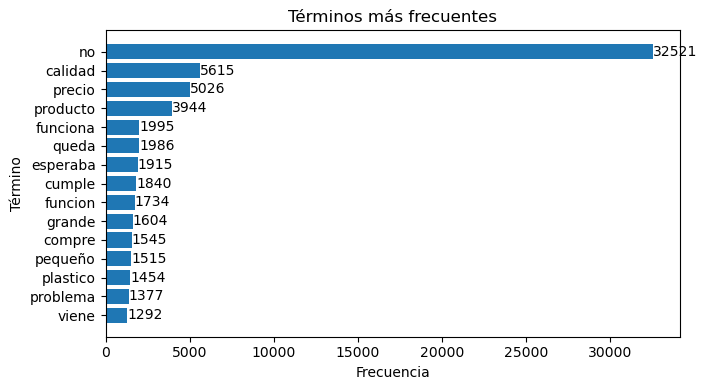

In [181]:
grafica_ngramas(data_train_3,'review_normalize',1)

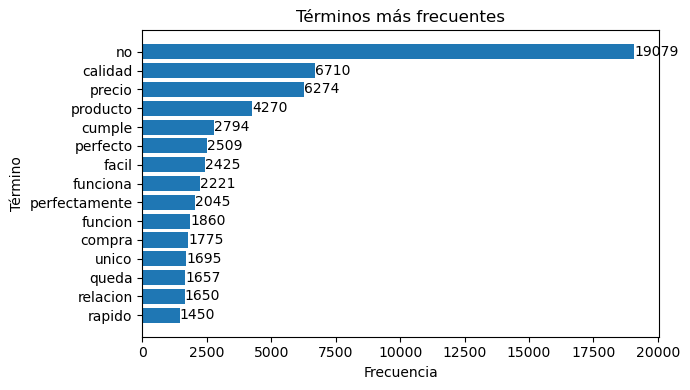

In [182]:
grafica_ngramas(data_train_4,'review_normalize',1)

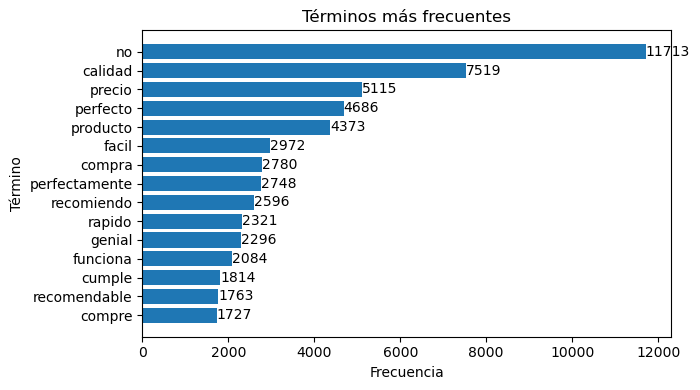

In [183]:
grafica_ngramas(data_train_5,'review_normalize',1)

En los unigramas se observa que la palabra "no" está presente en todas las categorías y de hecho es la que más está. Pero si observamos la frecuencia versus las otras palabras se puede notar que es mucho mayor en los comentarios de 1 y 2 estrellas. Es por esta razón que considero que la palabra no sí puede aportarme mucha información de la categoría asignada a cada reseña.

Por otro lado, en los comentarios de 4 y 5 estrellas empiezan a aparecer palabras como recomendable y perfectamente que indican que el cliente está satisfecho con el producto recibido

### Bigramas


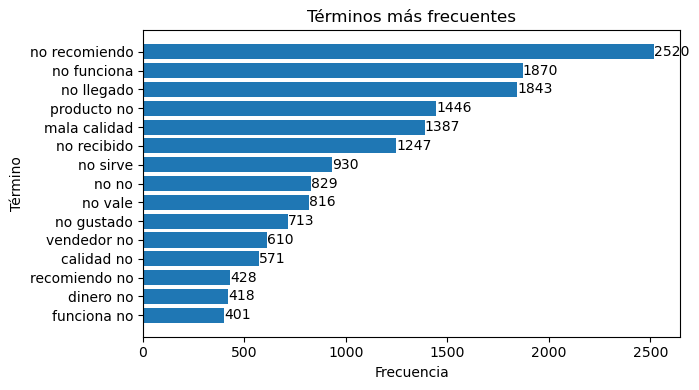

In [184]:
grafica_ngramas(data_train_1,'review_normalize',2)

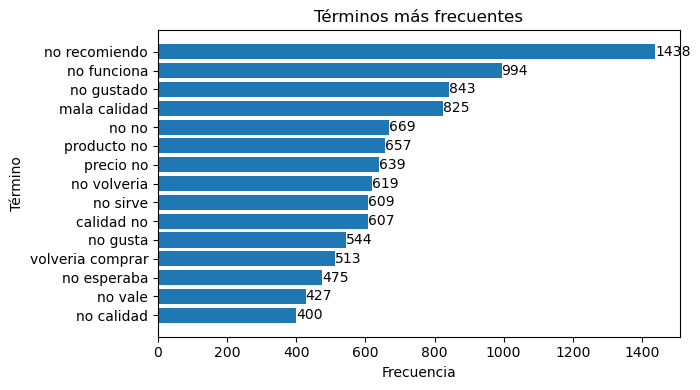

In [185]:
grafica_ngramas(data_train_2,'review_normalize',2)

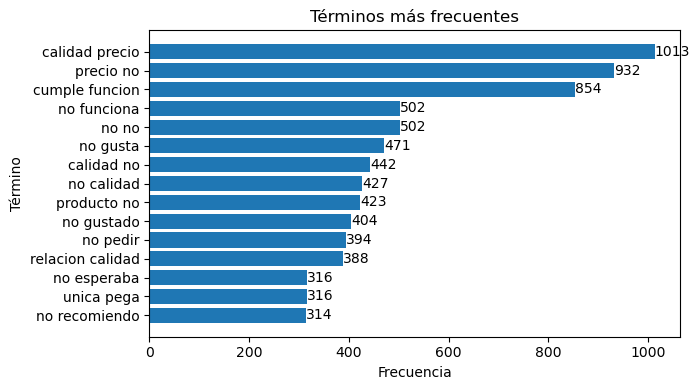

In [186]:
grafica_ngramas(data_train_3,'review_normalize',2)

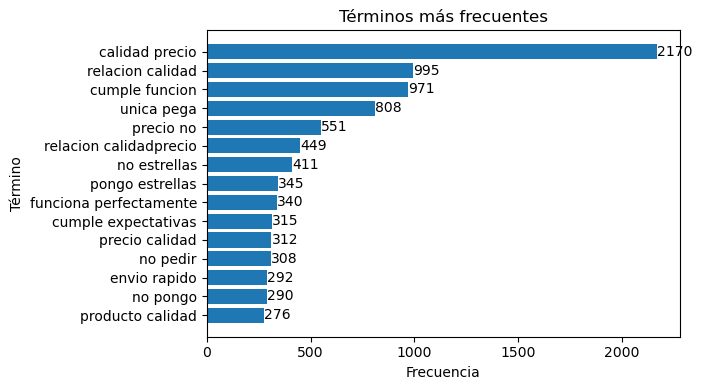

In [187]:
grafica_ngramas(data_train_4,'review_normalize',2)

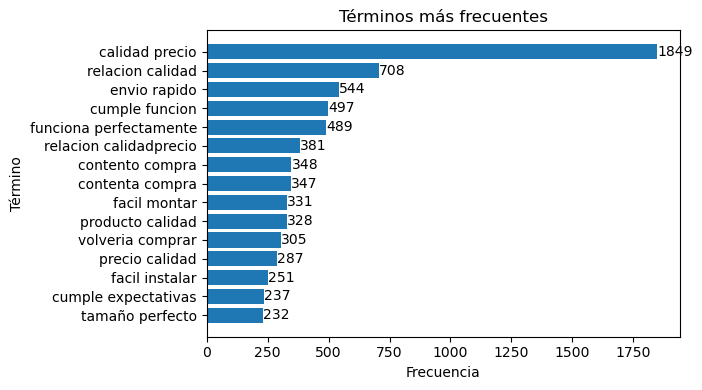

In [188]:
grafica_ngramas(data_train_5,'review_normalize',2)

De la gráfica de los bigramas se observa que estos comunican mejor el sentimiento de satisfacción con respecto al item recibido, aunque al ser dos palabras se disminuye considerablemente la frecuencia de estas y se podría obtener un modelo poco generalizable si trabajamos con bigramas. Es por esto que seguiremos trabajando con unigramas.

## Modelación

Se utilizará el conjunto de train para entrenar el modelo, el de test para optimizar los hiperparámetros y el de dev para obtener el desempeño del modelo con unos datos que simulan un ambiente productivo. 

En esta ocasión se utilizará el accuracy como métrica dado que los conjuntos de datos están completamente balanceados. El accuracy indica la razón entre las observaciones que el modelo predice correctamente sobre el número total de observaciones.

Voy a crear una función para normalizar el conjunto de datos partiendo de las funciones creadas arribas para limpiar y lematizar el texto

In [189]:

def normalizar(text, stop_words, activar_excluir = True):
    data = limpieza_datos(text,stop_words)
    data = limpieza_acentos(data)
    data = limpieza_longitud(data)
    data = lemmatizar(data)
    return data

In [190]:
data_test

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase
...,...,...,...,...,...,...,...,...
4995,es_0685611,product_es_0919143,reviewer_es_0461769,5,Para lo que cuesta es perfecto porque cumple s...,Perfectos para lo que sirven,es,wireless
4996,es_0638242,product_es_0636134,reviewer_es_0214562,5,"Material muy flexible y cómodo, acorde a la de...","Buen vendedor, rápido y fiable.",es,wireless
4997,es_0760108,product_es_0078583,reviewer_es_0043609,5,Se ve bien el grabado,medallas con bonito grabado,es,home
4998,es_0070806,product_es_0359350,reviewer_es_0258717,5,lo compré para mi bici pero finalmente se lo h...,timbre,es,sports


In [191]:
%%time 
data_test['review_normalize'] = data_test.review_body.apply(lambda  x: normalizar(x,stopwords))

Wall time: 42.9 s


In [192]:
%%time 
data_dev['review_normalize'] = data_dev.review_body.apply(lambda  x: normalizar(x,stopwords))

Wall time: 42.9 s


In [193]:
data_train.head()

,stars,review_body,review_normalize,review_lemmatize
0,1,Nada bueno se me fue ka pantalla en menos de 8...,pantalla meses no recibido respuesta fabricante,pantalla mesar no recibir respuesta fabricante
1,1,"Horrible, nos tuvimos que comprar otro porque ...",horrible tuvimos comprar ingles informatico ho...,horrible tener comprar ingle informatico hora ...
2,1,Te obligan a comprar dos unidades y te llega s...,obligan comprar unidades llega no forma reclam...,obligar comprar unidad llegar no formar reclam...
3,1,"No entro en descalificar al vendedor, solo pue...",no entro descalificar vendedor meses espera si...,no entrar descalificar vendedor mesar esperar ...
4,1,Llega tarde y co la talla equivocada,llega talla equivocada,llegar tallar equivocar


In [194]:
data_test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,review_normalize
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless,no llegar articular mandar correo normal segui...
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home,mensajeria horrible no comprar
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy,decepcionar vendedor pedir no no cumplio plazo...
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home,valoracion no producto amazon ofreceis product...
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase,interes librar probe version kindle abrir port...


Se separa la variable predictora de la variable a predecir en dos conjuntos de datos: X y Y para Train y Test.

In [195]:
X_train = data_train['review_normalize']
y_train = data_train['stars']

X_test = data_test['review_normalize']
y_test = data_test['stars']

Luego procederé a vectorizar los datos. La vectorización de palabras es una metodología de procesamiento de lenguaje natural para mapear palabras o frases a vectores correspondientes de numeros reales los cuales son usados para encontrar predicciones de palabras o similitudes entre palabras.

Existen varías técnicas para realizar esta tarea pero en este problema se utilizará bag of words. En bag of words se crea una matriz con las n palabras más frecuentes y en cada registro coloca 1 o 0 indicando si el comentario contiene la palabra o no. El valor de n se puede especificar como un parámetro.

Para la construcción de los modelos se hará uso de la librería Pipeline. Esta librería permite crear flujos de trabajo y aplicar funciones con cierta secuencia. Adicionalmente, podemos aplicar Grid Search lo c ual permitirá encontrar el modelo con el mejor performance.

### Modelo Benchmark - Árbol de Decisión

Utilizaré arbol de decisión como modelo benchmark, con profundidad máxima de 20. Para la vectorización utilizaré un máximo de 1000 palabras.

In [196]:
from collections import Counter
results = Counter()
data_train['review_normalize'].str.split().apply(results.update)
print(f'Numero de palabras actualmente en el dataset: {len(results)}')


Numero de palabras actualmente en el dataset: 66167


In [197]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [198]:
steps_tree = [('vectorizer', CountVectorizer(max_features=1000)), ('Tree', DecisionTreeClassifier(max_depth=20,
                                                                                                   random_state = 42))] 
pipeline_tree = Pipeline(steps_tree)

In [199]:
%%time
pipeline_tree.fit(X_train, y_train)

Wall time: 11.8 s


Pipeline(steps=[('vectorizer', CountVectorizer(max_features=1000)),
                ('Tree',
                 DecisionTreeClassifier(max_depth=20, random_state=42))])

In [200]:
y_train_pred_tree = pipeline_tree.predict(X_train)
y_test_pred_tree = pipeline_tree.predict(X_test)
accuracy_train_tree = accuracy_score(y_train, y_train_pred_tree)
accuracy_test_tree = accuracy_score(y_test, y_test_pred_tree)
print(f'Accuracy en Train: {round(accuracy_train_tree*100,2)}')
print(f'Accuracy en Test: {round(accuracy_test_tree*100,2)}')

Accuracy en Train: 38.8
Accuracy en Test: 31.5


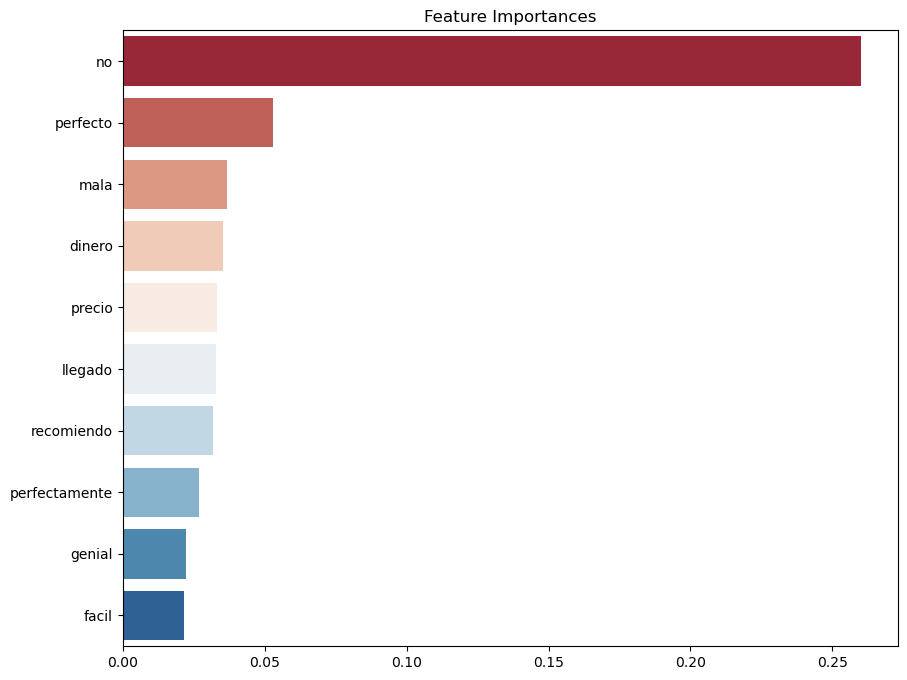

In [201]:
importances = pipeline_tree['Tree'].feature_importances_
indices = np.argsort(importances)[::-1]
columns = np.array(pipeline_tree['vectorizer'].get_feature_names())

plt.figure(figsize=(10, 8))
sns.barplot(importances[indices][:10], columns[indices][:10], palette="RdBu")
plt.title('Feature Importances')
plt.show()

Del gráfico de la importancia de las palabras que tiene el modelo a la hora de predecir se obseva que la palabra "no" es mucho más importante con respecto a la siguiente que es perfecto. También se observa que dentro de las palabras más importantes están las que permiten identificar facilmente si un comentario es bueno o malo por lo que se podría esperar que el modelo funcione muy bien con comentarios pertenecientes a 1 estrella y 5 estrellas.

Ahora vamos a analizar el classification report de nuestro modelo. El classification report muestra las métricas precision, recall, f1-score y support.

In [202]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_tree))

              precision    recall  f1-score   support

           1       0.50      0.15      0.23      1000
           2       0.29      0.57      0.39      1000
           3       0.26      0.02      0.04      1000
           4       0.26      0.54      0.35      1000
           5       0.49      0.30      0.37      1000

    accuracy                           0.32      5000
   macro avg       0.36      0.32      0.27      5000
weighted avg       0.36      0.32      0.27      5000



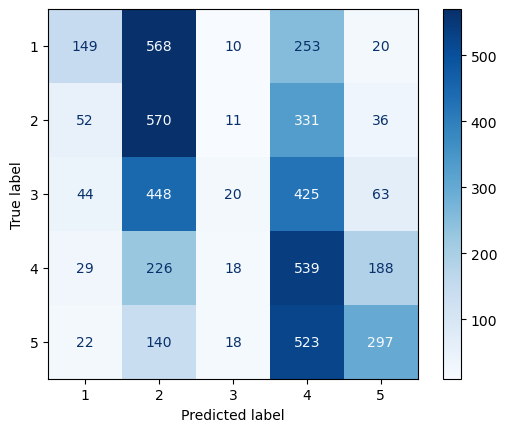

In [203]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline_tree, X_test, y_test, cmap=plt.cm.Blues, values_format = '.0f')
plt.show()

Del classification report y la gráfica de la matriz de confusión se puede observar que existe una alta precisión en los comentarios de 1 y 5 estrellas lo que afirma una mejora en el comportamiento del modelo si se tienen en cuenta sólo comentaroos positivos o negativos. Lo que nos dice la métrica support es el número de ocurrencias de dicha clase dentro de todo el dataset, todos están en 1 porque nuestro dataset está balanceado.

# Support Vector Machine - Kernel Lineal

In [204]:
from sklearn.svm import LinearSVC

In [205]:
steps_svm = [('vectorizer', CountVectorizer()), ('SVM', LinearSVC(random_state = 42))] 
pipeline_svm = Pipeline(steps_svm) 

In [206]:
param_grid_svm = {'vectorizer__max_features': [500, 1000, 1500, 2000],
                  'SVM__C': [0.1, 1, 10],
                  'SVM__penalty': ['l1', 'l2']}

In [207]:
%%time
grid_svm = GridSearchCV(pipeline_svm, param_grid=param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)

Wall time: 1h 33min 41s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('SVM', LinearSVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'SVM__C': [0.1, 1, 10], 'SVM__penalty': ['l1', 'l2'],
                         'vectorizer__max_features': [500, 1000, 1500, 2000]},
             scoring='accuracy')

In [208]:
print("Mejores Hiperparámetros:", grid_svm.best_params_)
print("Mejor Accuracy Promedio Obtenid - Test:", round(grid_svm.best_score_*100,2))

Mejores Hiperparámetros: {'SVM__C': 0.1, 'SVM__penalty': 'l2', 'vectorizer__max_features': 2000}
Mejor Accuracy Promedio Obtenid - Test: 45.95


In [209]:
y_train_pred_svm = grid_svm.predict(X_train)
y_test_pred_svm = grid_svm.predict(X_test)
accuracy_train_svm = accuracy_score(y_train, y_train_pred_svm)
accuracy_test_svm = accuracy_score(y_test, y_test_pred_svm)
print(f'Accuracy - Train: {round(accuracy_train_svm*100,2)}')
print(f'Accuracy - Test: {round(accuracy_test_svm*100,2)}')

Accuracy - Train: 48.41
Accuracy - Test: 40.1


In [210]:
print(classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

           1       0.48      0.59      0.53      1000
           2       0.32      0.29      0.30      1000
           3       0.29      0.27      0.28      1000
           4       0.39      0.21      0.27      1000
           5       0.46      0.64      0.54      1000

    accuracy                           0.40      5000
   macro avg       0.39      0.40      0.38      5000
weighted avg       0.39      0.40      0.38      5000



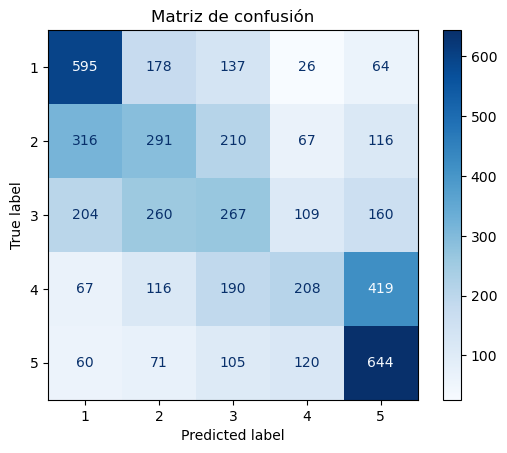

In [212]:
plot_confusion_matrix(grid_svm, X_test, y_test, cmap=plt.cm.Blues, values_format = '.0f')
plt.title('Matriz de confusión')
plt.show()

## Random Forest

In [213]:
from sklearn.ensemble import RandomForestClassifier

In [214]:
steps_rf = [('vectorizer', CountVectorizer()), ('RandomForest', RandomForestClassifier(n_estimators = 100, random_state=42))] 
pipeline_rf = Pipeline(steps_rf) 

In [215]:
param_grid_rf = {'vectorizer__max_features': [500, 1000, 1500, 2000],
                 'RandomForest__max_depth': np.arange(10,30,5),
                 'RandomForest__max_features': ['sqrt', 'log2', 'auto']}

In [216]:
%%time
rf_grid = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

Wall time: 46min 33s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('RandomForest',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'RandomForest__max_depth': array([10, 15, 20, 25]),
                         'RandomForest__max_features': ['sqrt', 'log2', 'auto'],
                         'vectorizer__max_features': [500, 1000, 1500, 2000]},
             scoring='accuracy')

In [217]:
print("Mejores Hiperparámetros:", rf_grid.best_params_)
print("Mejor Accuracy Promedio Obtenido - Test:", round(rf_grid.best_score_*100,2))

Mejores Hiperparámetros: {'RandomForest__max_depth': 25, 'RandomForest__max_features': 'log2', 'vectorizer__max_features': 2000}
Mejor Accuracy Promedio Obtenido - Test: 43.32


In [218]:
y_train_pred_rf = rf_grid.predict(X_train)
y_test_pred_rf = rf_grid.predict(X_test)
accuracy_train_rf = accuracy_score(y_train, y_train_pred_rf)
accuracy_test_rf = accuracy_score(y_test, y_test_pred_rf)
print(f'Accuracy - Train: {round(accuracy_train_rf*100,2)}')
print(f'Accuracy - Test: {round(accuracy_test_rf*100,2)}')

Accuracy - Train: 49.56
Accuracy - Test: 39.9


In [219]:
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           1       0.52      0.51      0.51      1000
           2       0.33      0.41      0.37      1000
           3       0.33      0.12      0.18      1000
           4       0.39      0.20      0.27      1000
           5       0.40      0.75      0.52      1000

    accuracy                           0.40      5000
   macro avg       0.39      0.40      0.37      5000
weighted avg       0.39      0.40      0.37      5000



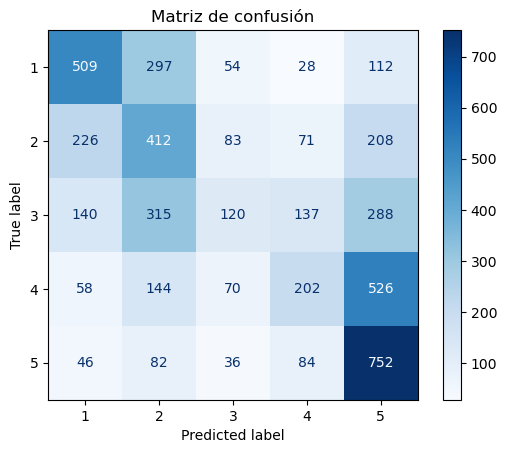

In [220]:
plot_confusion_matrix(rf_grid, X_test, y_test, cmap=plt.cm.Blues, values_format = '.0f')
plt.title('Matriz de confusión')
plt.show()


Al correr los modelos anteriores en el conjunto de test se tienen los siguientes accuracy:

* Árbol de decisión (benchmark): **31.5%**
* Support vector machine - kernel lineal: **40.1%**
* Random forest: **39.9%**

Con el que se obtuvo el mejor accuracy fue con support vector machine con kernel lineal por lo tanto ese va a ser nuestro modelo elegido.

Al revisar el comportamiento de los modelos se observa que el modelo podría mejorar si se convierte el problema en uno binario, es por esto que se va a realizar el cambio para comprobarlo.


## Problema binario: Comentarios positivos o negativos

Se convertirá el problema en binario mapeando los comentarios de 1, 2, 3, 4 y 5 estrellas en dos grupos: comentarios positivos y negativos. Los comentarios con 4 y 5 estrellas se tomarán como comentarios positivos y como negativos los de 1 y 2 estrellas. Los comentarios de 3 estrellas no se incluirán en el análisis porque se consideran neutrales.

In [221]:
data_train_binario = data_train[data_train.stars != 3]
data_test_binario = data_test[data_test.stars != 3]

In [222]:
data_train_binario['Ind_Positivo'] = np.where(data_train_binario.stars >= 4, 1, 0)
data_test_binario['Ind_Positivo'] = np.where(data_test_binario.stars >= 4, 1, 0)

<ipython-input-222-57186ecbce83>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_binario['Ind_Positivo'] = np.where(data_train_binario.stars >= 4, 1, 0)
<ipython-input-222-57186ecbce83>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_binario['Ind_Positivo'] = np.where(data_test_binario.stars >= 4, 1, 0)


In [223]:
X_train_binario = data_train_binario['review_normalize']
y_train_binario = data_train_binario['Ind_Positivo']

X_test_binario = data_test_binario['review_normalize']
y_test_binario = data_test_binario['Ind_Positivo']

En este punto se ejecutarán nuevamente los modelos realizados anteriormente pero para nuestro problema binario.


### Árbol de decisión

In [224]:
steps_tree_binario = [('vectorizer', CountVectorizer(max_features=1000)), ('Tree', DecisionTreeClassifier(max_depth=20,
                                                                                                          random_state = 42))] 
pipeline_tree_binario = Pipeline(steps_tree_binario)

In [225]:
%%time
pipeline_tree_binario.fit(X_train_binario, y_train_binario)

Wall time: 7.28 s


Pipeline(steps=[('vectorizer', CountVectorizer(max_features=1000)),
                ('Tree',
                 DecisionTreeClassifier(max_depth=20, random_state=42))])

In [226]:
y_train_pred_tree_binario = pipeline_tree_binario.predict(X_train_binario)
y_test_pred_tree_binario = pipeline_tree_binario.predict(X_test_binario)
accuracy_train_tree_binario = accuracy_score(y_train_binario, y_train_pred_tree_binario)
accuracy_test_tree_binario = accuracy_score(y_test_binario, y_test_pred_tree_binario)
print(f'Accuracy en Train: {round(accuracy_train_tree_binario*100,2)}')
print(f'Accuracy en Test: {round(accuracy_test_tree_binario*100,2)}')

Accuracy en Train: 79.02
Accuracy en Test: 74.02


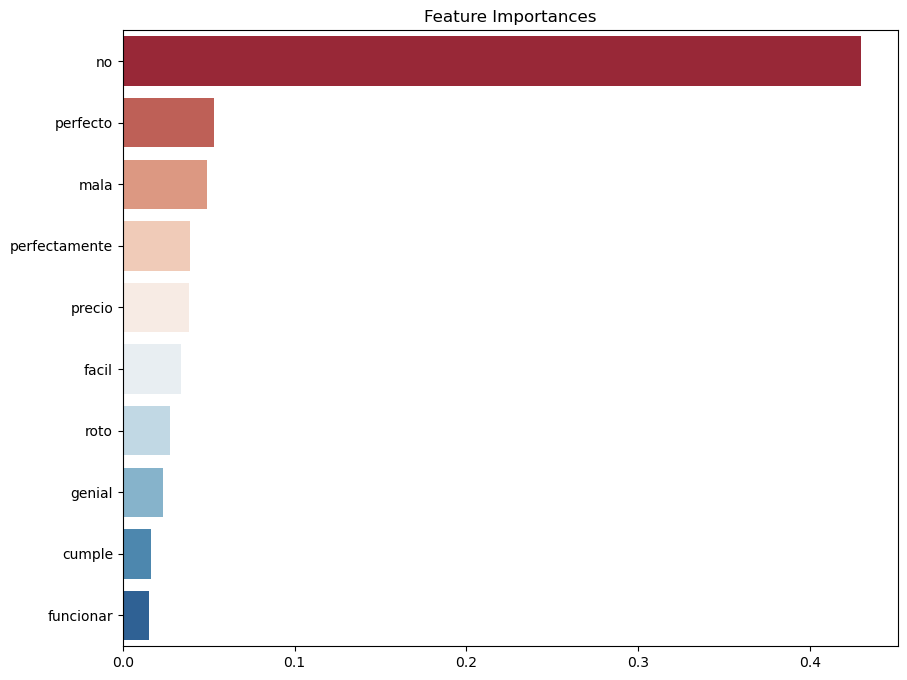

In [227]:
importances_binario = pipeline_tree_binario['Tree'].feature_importances_
indices_binario = np.argsort(importances_binario)[::-1]
columns_binario = np.array(pipeline_tree_binario['vectorizer'].get_feature_names())

plt.figure(figsize=(10, 8))
sns.barplot(importances_binario[indices_binario][:10], columns_binario[indices_binario][:10], palette="RdBu")
plt.title('Feature Importances')
plt.show()

Se observa que para el modelo binario también la palabra no tiene la mayor importancia y supera por mucho a la palabra siguiente que es "perfecto" lo que me hace pensar que fue buena decisión dejarla y no eliminarla por tener menos de 3 letras.

In [228]:
print(classification_report(y_test_binario, y_test_pred_tree_binario))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      2000
           1       0.72      0.79      0.75      2000

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



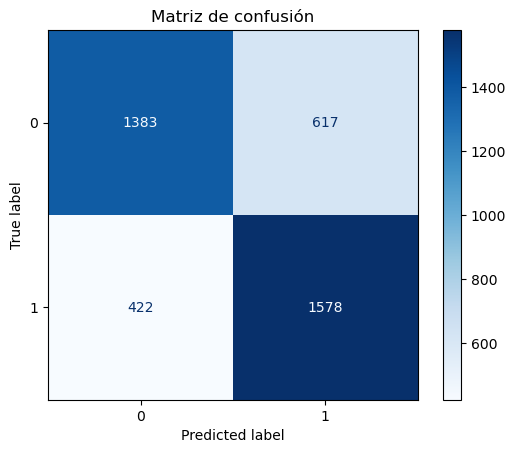

In [229]:
plot_confusion_matrix(pipeline_tree_binario, X_test_binario, y_test_binario, cmap=plt.cm.Blues, values_format = '.0f')
plt.title('Matriz de confusión')
plt.show()

### Support Vector Machine - Kernel Lineal

In [230]:
steps_svm_binario = [('vectorizer', CountVectorizer()), ('SVM', LinearSVC(random_state = 42))] 
pipeline_svm_binario = Pipeline(steps_svm_binario) 

In [231]:
%%time
grid_svm_binario = GridSearchCV(pipeline_svm_binario, param_grid=param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm_binario.fit(X_train_binario, y_train_binario)

Wall time: 12min 33s


C:\Users\Daniela Diazgranados\Anaconda3\envs\datascience\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('SVM', LinearSVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'SVM__C': [0.1, 1, 10], 'SVM__penalty': ['l1', 'l2'],
                         'vectorizer__max_features': [500, 1000, 1500, 2000]},
             scoring='accuracy')

In [232]:
print("Mejores Hiperparámetros:", grid_svm_binario.best_params_)
print("Mejor Accuracy Promedio Obtenido en Test:", round(grid_svm_binario.best_score_*100,2))

Mejores Hiperparámetros: {'SVM__C': 10, 'SVM__penalty': 'l2', 'vectorizer__max_features': 2000}
Mejor Accuracy Promedio Obtenido en Test: 84.57


In [233]:
y_train_pred_svm_binario = grid_svm_binario.predict(X_train_binario)
y_test_pred_svm_binario = grid_svm_binario.predict(X_test_binario)
accuracy_train_svm_binario = accuracy_score(y_train_binario, y_train_pred_svm_binario)
accuracy_test_svm_binario = accuracy_score(y_test_binario, y_test_pred_svm_binario)
print(f'Accuracy en Train: {round(accuracy_train_svm_binario*100,2)}')
print(f'Accuracy en Test: {round(accuracy_test_svm_binario*100,2)}')

Accuracy en Train: 86.18
Accuracy en Test: 80.15


In [234]:
print(classification_report(y_test_binario, y_test_pred_svm_binario))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81      2000
           1       0.82      0.77      0.80      2000

    accuracy                           0.80      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.80      0.80      0.80      4000



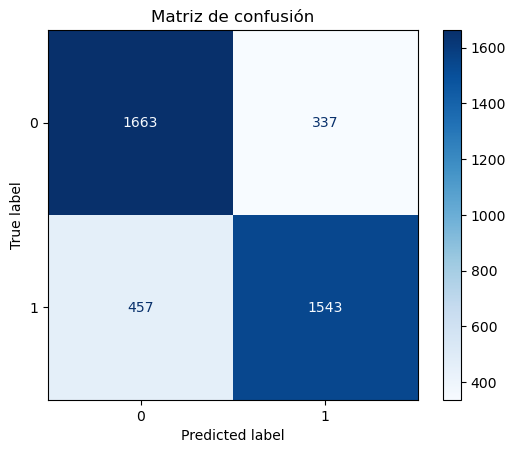

In [235]:
plot_confusion_matrix(grid_svm_binario, X_test_binario, y_test_binario, cmap=plt.cm.Blues, values_format = '.0f')
plt.title('Matriz de confusión')
plt.show()

Se observa que el modelo mejora mucho y puede predecir bien los positivos y negativos

### Random Forest

In [236]:
steps_rf_binario = [('vectorizer', CountVectorizer()), ('RandomForest', RandomForestClassifier(n_estimators = 100, 
                                                                                               random_state=42))] 
pipeline_rf_binario = Pipeline(steps_rf_binario)

In [237]:
%%time
rf_grid_binario = GridSearchCV(pipeline_rf_binario, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_binario.fit(X_train_binario, y_train_binario)

Wall time: 29min 38s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('RandomForest',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'RandomForest__max_depth': array([10, 15, 20, 25]),
                         'RandomForest__max_features': ['sqrt', 'log2', 'auto'],
                         'vectorizer__max_features': [500, 1000, 1500, 2000]},
             scoring='accuracy')

In [238]:
print("Mejores Hiperparámetros:", rf_grid_binario.best_params_)
print("Mejor Accuracy Promedio Obtenido - Test:", round(rf_grid_binario.best_score_*100,2))

Mejores Hiperparámetros: {'RandomForest__max_depth': 25, 'RandomForest__max_features': 'log2', 'vectorizer__max_features': 1500}
Mejor Accuracy Promedio Obtenido - Test: 81.31


In [239]:
y_train_pred_rf_binario = rf_grid_binario.predict(X_train_binario)
y_test_pred_rf_binario = rf_grid_binario.predict(X_test_binario)
accuracy_train_rf_binario = accuracy_score(y_train_binario, y_train_pred_rf_binario)
accuracy_test_rf_binario = accuracy_score(y_test_binario, y_test_pred_rf_binario)
print(f'Accuracy en Train: {round(accuracy_train_rf_binario*100,2)}')
print(f'Accuracy en Test: {round(accuracy_test_rf_binario*100,2)}')

Accuracy en Train: 82.92
Accuracy en Test: 77.42


In [240]:
print(classification_report(y_test_binario, y_test_pred_rf_binario))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      2000
           1       0.76      0.79      0.78      2000

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.77      0.77      4000



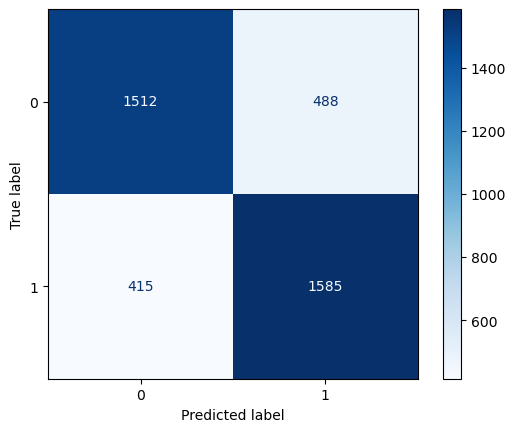

In [241]:
plot_confusion_matrix(rf_grid_binario, X_test_binario, y_test_binario, cmap=plt.cm.Blues, values_format = '.0f')
plt.show()

Al comparar los resultados de los modelos aplicados a nuestro problema binario en el conjunto de test se tiene:

* Árbol de decisión (benchmark): **74.02%**
* Support vector machine - kernel lineal: **80.15%**
* Random forest: **77.42%**

Para todos los modelos el accuracy mejoró considerablemente al cambiar el problema a binario. El algoritmo support vector machine también tuvo en esete caso el mejor desempeño por lo que se escoje como el mejor modelo para este problema.

Se observa que para todos los modelos aplicados, el resultado de la métrica mejoró considerablemente, pero nuevamente se obtiene el algoritmo de Support vector machine con kernel lineal como el que permite tener el mejor modelo para nuestro problema.

## Simulación producción
### Modelo final

In [242]:
X_dev = data_dev['review_normalize']
y_dev = data_dev['stars']

In [243]:
y_test_dev_svm = grid_svm.predict(X_dev)
accuracy_dev_svm = accuracy_score(y_dev, y_test_dev_svm)
print(f'Accuracy en Dev: {round(accuracy_dev_svm*100,2)}')

Accuracy en Dev: 41.16


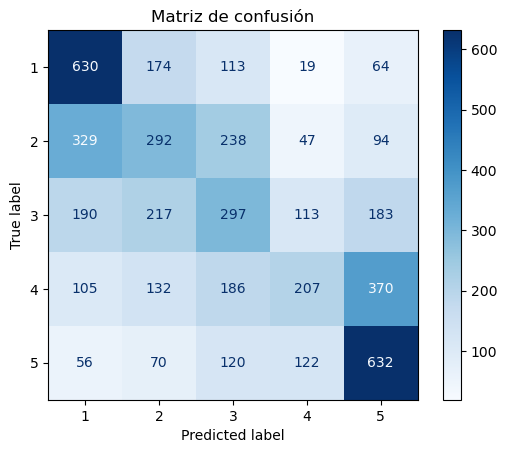

In [244]:
plot_confusion_matrix(grid_svm, X_dev, y_dev, cmap=plt.cm.Blues, values_format = '.0f')
plt.title('Matriz de confusión')
plt.show()

### Modelo binario

In [245]:
data_dev_bin = data_dev[data_dev.stars != 3]

In [246]:
data_dev_bin['Ind_Positivo'] = np.where(data_dev_bin.stars >= 4, 1, 0)

<ipython-input-246-0d3eb6796580>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dev_bin['Ind_Positivo'] = np.where(data_dev_bin.stars >= 4, 1, 0)


In [247]:
X_dev_bin = data_dev_bin['review_normalize']
y_dev_bin = data_dev_bin['Ind_Positivo']

In [249]:
y_dev_pred_svm_bin = grid_svm_binario.predict(X_dev_bin)
accuracy_dev_svm_bin = accuracy_score(y_dev_bin, y_dev_pred_svm_bin)
print(f'Accuracy en Dev: {round(accuracy_dev_svm_bin*100,2)}')

Accuracy en Dev: 79.62


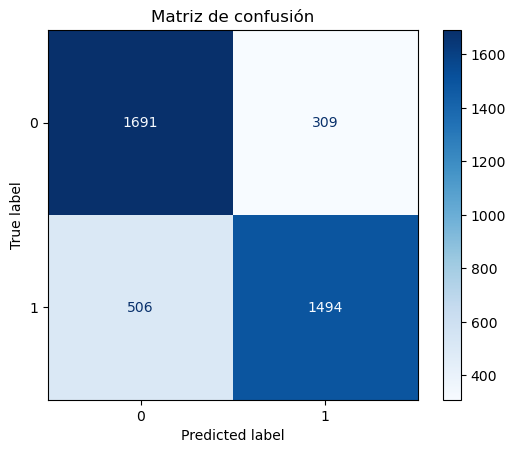

In [250]:
plot_confusion_matrix(grid_svm_binario, X_dev_bin, y_dev_bin, cmap=plt.cm.Blues, values_format = '.0f')
plt.title('Matriz de confusión')
plt.show()

De la ejecución de los dos modelos en "producción" se puede decir que el comportamiento es el esperado, el accuracy obtenido no es muy diferente al obtenido en test por lo que nuestro modelo tiene una buena capacidad de generalizar. Como era de esperarse también, el comportamiento sigue siendo mucho mejor para el problema binario en comparación con el multiclase.

## Conclusiones

* El modelo realizado con el algoritmo support vector machine con kernel lineal fue superior en desempeño a los realizados con arboles de decisión y random forest.

* Utilizar librerias especializadas para este tipo de problemas facilita mucho todo el manejo de los datos. Además, cabe resaltar el poder de las expresiones regulares, su uso puede disminuir significativamente los tiempos de ejecución de las tareas.

* Se podría mejorar en la parte de la lematización el tener en cuenta el contexto de la palabra en la frase, dado que palabras diferentes pueden tener el mismo lema pero estar haciendo papeles diferentes en la oración. Por ejemplo: una puede estar de sustantivo y la otra de verbo.

* Sería interesante mirar cómo se comportaría el modelo si se aplica por ejemplo una técnica diferente de vectorización como TF-IDF o corregir la ortografía de algunas palabras y así mirar si el modelo puede mejorar.
